In [ ]:
import numpy as np
import math, sys, os, yaml, scipy
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
import scipy.interpolate as spline
from tqdm.notebook import tqdm

############################ GQCA functions for phase diagram #################

class Phase_diagram:

  def __init__(self, nj, ej, dej, gj):

    """
    Calculates the phase diagramas through GQCA approach
    """

    # inputs

    self.nj = nj
    self.n = nj[-1]
    self.dej = dej
    self.J = len(ej)
    self.gj = gj
    self.kb = 8.6173324e-5 # Boltzmann constant eV/K

    # output

    self.fmix_val = 0.0
    self.smix_val = 0.0
    self.sec_diff_val = 0.0
    self.eta = 0.0
    self.etot = 0.0

 # Obtain roots of polynomial equation

  def root_lagrange_multiplier(self, x, T):

    """
    Calculates the Lagrange Multiplier regarding composition constrain in GQCA probabilities.

    Parameters:
        x (float): The composition of alloy, such as 0<=x<=1.
        T (float): Temperature in Kelvin.
    Returns:
        eta (float): The value of Lagrange multiplier.
    """

    coefs = np.zeros(n+1)
    beta = 1.0/(kb*T)

    i = n
    for jj in range(n+1):
      for k in range(J):
        if(nj[k] == i):
          coefs[jj] += (n*x-nj[k])*gj[k]*np.exp(-beta*dej[k])
      i = i-1

    raizes = np.roots(coefs) # can be complex

    for p in raizes: #Take the real
      if np.isreal(p) and p.real > 0.00e0:
        self.eta = p.real

    return self.eta

  # Probability to obtain configuration j

  def xj(self, j, T, eta):

    """
    Calculates the Cluster probabilities for each class in GQCA.

    Parameters:
        j (int): number of class, in the same order of the input file gqca_inputs.yml.
        T (float): Temperature in Kelvin.
        eta (float): The value of Lagrange multiplier within GQCA.
    Returns:
        xj (float): The value of cluster probability for the j-th class of alloy.
    """

    zpart = 0.0e0 #partition function
    beta = 1/(kb*T)

    for i in range(J): #Calculate partition function
        zpart += gj[i]*eta**nj[i]*np.exp(-beta*dej[i])

    return gj[j]*eta**nj[j]*np.exp(-beta*dej[j])/zpart

  # Probability associated with strict regular solution

  def xj0(self, j, x):

    """
    Calculates the Cluster probabilities associated with a regular solution.

    Parameters:
        j (int): number of class, in the same order of the input file gqca_inputs.yml.
        x (float): The composition of alloy, such as 0<=x<=1.
    Returns:
        xj0 (float): The value of cluster probability in the limit of a regular solution for the j-th class of alloy.
    """

    return gj[j]*(x**nj[j])*((1-x)**(n-nj[j]))

  # Mixing energy

  def emix(self, x, T):

    """
    Calculates the mixing energy for the alloy at a given composition and temperature.

    Parameters:
        x (float): The composition of alloy, such as 0<=x<=1.
        T (float): Temperature in Kelvin.
    Returns:
        emix (float): The value of mixing energy for the alloy at composition x and temperature T.
    """

    if x in [0.0, 1.0]:
      return 0.0e0
    eta = self.root_lagrange_multiplier(x, T)
    etot = 0.0e0
    for i in range(J):
        etot += self.xj(i, T, eta)*dej[i]
    return etot

  # Mixing entropy

  def smix(self, x, T):
    """
    Calculates the mixing entropy for the alloy at a given composition and temperature.

    Parameters:
        x (float): The composition of alloy, such as 0<=x<=1.
        T (float): Temperature in Kelvin.
    Returns:
        smix (float): The value of mixing entropy for the alloy at composition x and temperature T.
    """

    if x in [0.0, 1.0]:
      return 0.0e0
    eta = self.root_lagrange_multiplier(x, T)
    klf = 0.00e0
    for i in range(J): # Kullbach-Leibler factor
      klf += self.xj(i, T, eta)*np.log(self.xj(i, T, eta)/self.xj0(i,x))

    self.smix_val = -kb*(x*np.log(x) + (1-x)*np.log(1-x) + (klf/n))
    return self.smix_val

  # Mixing Free energy, per cation

  def fmix(self, x, T):

    """
    Calculates the mixing Helmholtz free energy for the alloy at a given composition and temperature.

    Parameters:
        x (float): The composition of alloy, such as 0<=x<=1.
        T (float): Temperature in Kelvin.
    Returns:
        fmix (float): The value of mixing Helmholtz free energy for the alloy at composition x and temperature T.
    """

    self.fmix_val = self.emix(x,T) - T*self.smix(x,T)

    return self.fmix_val

  #Kullback-Leibler Divergence
  def kld(self, x, T):
    """
    Calculates the Kullback-Leibler Divergence D_{KL}(xj||xj0) between the xj and xj0 probability distributions.

    Parameters:
        x (float): The composition of alloy, such as 0<=x<=1.
        T (float): Temperature in Kelvin.
    Returns:
        dkl (float): The value of Kullback-Leibler Divergence at composition x and temperature T.
    """

    dkl = 0.0e0
    eta = self.root_lagrange_multiplier(x, T)

    for i in range(J): # Kullback-Leibler factor
      dkl += self.xj(i, T, eta)*np.log(self.xj(i, T, eta)/self.xj0(i,x))

    return dkl

  # Second Derivative

  def second_derivative(self, x, T):

    """
    Calculates the second derivative of the Helmholtz free energy using finite differences

    Parameters:
        x (float): The composition of alloy, such as 0<=x<=1.
        T (float): Temperature in Kelvin.
    Returns:
        d2fmix/dx2 (float): The second derivative at composition x and temperature T.
    """

    h = 1.0e-6
    if (x == 0.0): # progressive finite difference
      xp1 = x + h
      xp2 = x + 2*h
      xp3 = x + 3*h
      self.sec_diff_val = (-self.fmix(xp3, T) + 4 * self.fmix(xp2, T) -
                           5 * self.fmix(xp1, T) + 2 * self.fmix(x, T)) / h**2
    elif (x == 1.0): # regressive finite difference
      xm1 = x - h
      xm2 = x - 2*h
      xm3 = x - 3*h
      self.sec_diff_val = (2.0 * self.fmix(x, T) - 5.0 * self.fmix(xm1, T) +
                           4.0 * self.fmix(xm2, T) - self.fmix(xm3, T)) / h**2
    else:     # centered finite difference
      xp1 = x + h
      xm1 = x - h
      self.sec_diff_val = (
          self.fmix(xp1, T) - 2 * self.fmix(x, T) + self.fmix(xm1, T)) / h**2

    return self.sec_diff_val

  def f_temp(self, xa, xb, xc, T): #####Tentativa de criação de função. Ainda não utilizada

    return ((xa-xb)*self.fmix(xc,T)+(xc-xa)*self.fmix(xb,T))/(xc-xb)


# Open the gqca input files

In [ ]:
with open('/content/gqca_inputs.yml') as file:
  gqca_inputs = yaml.full_load(file)

#print(gqca_inputs)

# GQCA inputs parameters

In [ ]:
ncell = 1 #variable for expansion supercell
natomos = 1 #number of atoms by unit cell
kb = 8.6173324e-5 #Boltzmann constant eV/K
ncell = gqca_inputs['supercell'] # supercell size
n_atoms = gqca_inputs['species_by_unit_cell'][0] # species by unit cell
ej = gqca_inputs['total_energy_Ej']  # cluster energy list
ej = np.array(gqca_inputs['total_energy_Ej'])/(math.prod(ncell)*n_atoms)  # energy normalization
ej = ej.tolist()
gj = gqca_inputs['classes_degeneracy_gj']  # degeneracy factors list
nj = gqca_inputs['nunber_of_replaced_species_nj']  # number of substitutions in each cluster

T0 = gqca_inputs['t_init'][0]
Tf = gqca_inputs['t_end'][0]
nT = gqca_inputs['t_points'][0]
xj = []  # cluster probability

In [ ]:
# n = nj[-1] # total number of substitutions in cluster

J = len(ej) # maximum number of classes
n = nj[-1]  # total number of substitutions in cluster

# Calculating the excess energies

dej_dict = {} # excess energy dict

dej = []
x = []

for j in range(J):
  temp_x = float(nj[j])/float(n)
  x.append(temp_x)
  dej.append((ej[j] - (1-temp_x)*ej[0] - temp_x*ej[-1])) # to meV/atom

dej_dict['x'] = x
dej_dict['DEj (meV/atom)'] = dej

with open("excess_energy.yml", "w") as out:
  yaml.dump(dej_dict, out, default_flow_style=False)


# Free energy calculation
# Parameters definition
# Composition

dT = (Tf-T0)/nT # Temperature intervals
x0 = 0.000
x1 = 1.000
nx = 100
dx = (x1-x0)/nx

# Temperature scan
# binodalp_file = open("binodal_points.dat", "w")
# espinodalp_file = open("espinodal_points.dat", "w")
qgca_class = Phase_diagram(nj, ej, dej, gj)

In [ ]:
i = 0
T = T0
nT1 = 100
dT1 = (Tf-T0)/nT1
xs0 = 0.0001

temp1 = [] # Temperatures for the spinodal line
temp2 = [] # Temperatures for the binodal line
esp = [] # spinodal compositions
bnd = [] # binodal compositions
m = 0

# First part: find the spinodal points
x_composition = np.linspace(0.001, 0.999, 200)

while dT1 > 0.000:
  tqdm(dT1)
  y_diff = []
  for temp_var in x_composition:
    temp_diff = qgca_class.second_derivative(temp_var,T)
    y_diff.append(temp_diff)

  d2free = CubicSpline(x_composition, y_diff) # Contains the second derivative of the free energy

  xesp = np.asarray(d2free.roots()) # Get all spinodal points
  xesp = np.sort(xesp)

  if(len(xesp) == 0):
      break
  else:
      for x_temp in xesp:
        #print("%.4f\t%.5f" %(xesp[i],T))
        temp1.append(float(T))
        esp.append(float(x_temp))

  if(len(xesp) == 2): # two spinodal points
    xc = (xesp[0] + xesp[1])/2.0
    x1 = xesp[0]
    x2 = xesp[1]

    def f1(x):
        return ((xc-x)*qgca_class.fmix(x2,T)+(x2-xc)*qgca_class.fmix(x,T))/(x2-x)
    def f2(x):
        return ((xc-x1)*qgca_class.fmix(x,T)+(x-xc)*qgca_class.fmix(x1,T))/(x-x1)

    #f1 = qgca_class.f_temp(xc, x, x2, T)
    #f2 = qgca_class.f_temp(xc, x1, x, T)
    # Search for binodal points
    h1 = 1.0
    h2 = 1.0
    k = 0
    while (h1>1e-6 or h2>1e-6):
        res = minimize_scalar(f1,bounds=(0.0001,xesp[0]), method='bounded')
        h1 = abs(x1-res.x)
        x1 = res.x
        res = minimize_scalar(f2,bounds=(xesp[1],0.9999), method='bounded')
        h2 = abs(x2-res.x)
        x2 = res.x
        k += 1
        if k == 10:
            break
    # Binodal points
    #print(T, x1, x2)
    xline = [x1,x2]

    for x_temp in xline:
        #print("%.4f\t%.5f" %(xline[i],T))
        temp2.append(float(T))
        bnd.append(float(x_temp))

  if (len(xesp)==4): #four spinodal points
    m=1
    xc1 = (abs(xesp[0])+xesp[1])/2.0
    x1 = abs(xesp[0])
    x2 = xesp[1]

    def f1(x):
        return ((xc1-x)*qgca_class.fmix(x2,T)+(x2-xc1)*qgca_class.fmix(x,T))/(x2-x)
    def f2(x):
        return ((xc1-x1)*qgca_class.fmix(x,T)+(x-xc1)*qgca_class.fmix(x1,T))/(x-x1)

    # Search for binodal points
    h1 = 1.0
    h2 = 1.0
    k = 0

    while (h1>1e-6 or h2>1e-6):
        res = minimize_scalar(f1,bounds=(0.0001,abs(xesp[0])), method='bounded')
        h1 = abs(x1-res.x)
        x1 = res.x
        res = minimize_scalar(f2,bounds=(xesp[1],xesp[2]-0.01), method='bounded')
        h2 = abs(x2-res.x)
        x2 = res.x
        k += 1
        if k == 10:
            break

    xc2 = (xesp[2]+xesp[3])/2.0
    x3 = xesp[2]
    x4 = xesp[3]

    def f3(x):
        return ((xc2-x)*qgca_class.fmix(x4,T)+(x4-xc2)*qgca_class.fmix(x,T))/(x4-x)
    def f4(x):
        return ((xc2-x3)*qgca_class.fmix(x,T)+(x-xc2)*qgca_class.fmix(x3,T))/(x-x3)

    # Search for binodal points
    h1 = 1.0
    h2 = 1.0
    k = 0
    while (h1>1e-6 or h2>1e-6):
        res = minimize_scalar(f3,bounds=(xesp[1],xesp[2]-0.001), method='bounded')
        h1 = abs(x3-res.x)
        x3 = res.x
        res = minimize_scalar(f4,bounds=(xesp[3]+0.0001,0.9999), method='bounded')
        h2 = abs(x4-res.x)
        x4 = res.x
        k += 1
        if k == 10:
            break
    # Binodal points
    #print(T, x1, x2, x3, x4)
    xline = [x1,x2, x3, x4]

    for x_temp in xline:
        temp2.append(float(T))
        bnd.append(float(x_temp))

  T1 = T
  T = T1 + dT1

temp1 = np.asarray(temp1)
temp2 = np.asarray(temp2)
esp = np.asarray(esp)
bnd = np.asarray(bnd)
esp, temp1 = zip(*sorted(zip(esp, temp1)))
bnd, temp2 = zip(*sorted(zip(bnd, temp2)))

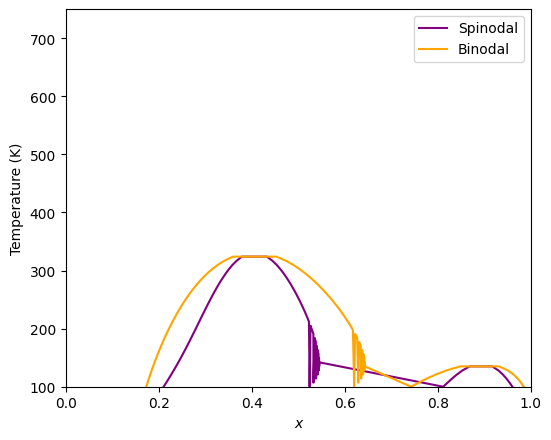

In [ ]:
# Plot of the properties

#fig, ax = plt.subplots(1,1,figsize=(12, 16))

fig=plt.figure(figsize=(6,5), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(esp, temp1, 'purple', label='Spinodal')
plt.plot(bnd, temp2, color='orange', label='Binodal')
plt.xlabel("x", style='italic')
plt.ylabel("Temperature (K)")
plt.ylim([100, 750])
plt.xlim([0.0, 1.00])
plt.legend()

plt.show()

# Thermodynamics properties

In [ ]:
num_points = 6
Temps = np.linspace(T0, Tf, num_points).tolist()
temp_x = np.linspace(0, 1.000, 100).tolist()


therm_props = {}
temp_prob= {}

# Temperature
for T in tqdm(Temps):
  temp_fmix = []
  temp_emix = []
  temp_smix = []
  temp_dict = {}

  for x in temp_x:
    temp_fmix.append(qgca_class.fmix(x,T)*1.0e3)
    temp_emix.append(qgca_class.emix(x,T)*1.0e3)
    temp_smix.append(T*qgca_class.smix(x,T)*1.0e3)

    for j in range(J):
        xj_list = []

        for x_comp in temp_x:
          temp_eta = qgca_class.root_lagrange_multiplier(x_comp, T)
          temp_xj = qgca_class.xj(j, T, temp_eta)
          xj_list.append(temp_xj)
          if(x_comp == 0 and j == 0):
            xj_list[0] = 1.0

          if(x_comp == 1 and j == (J-1)):
            xj_list[-1] = 1.0

        xj_list = np.array(xj_list, dtype=np.float64).tolist()
        temp_prob["Temperature_"+str(int(T)) + "Class=" + str(j+1)] = xj_list

    temp_dict["x"] = np.array(temp_x, dtype=np.float64).tolist()
    temp_dict["fmix"] = np.array(temp_fmix, dtype=np.float64).tolist()
    temp_dict["emix"] = np.array(temp_emix, dtype=np.float64).tolist()
    temp_dict["Tsmix"] = np.array(temp_smix, dtype=np.float64).tolist()
    therm_props["Temperature_"+str(int(T))] = temp_dict


with open("Thermo_properties.yml", "w") as out:
  yaml.dump(therm_props, out, default_flow_style=False)

with open("Cluster_probability.yml", "w") as out:
  yaml.dump(temp_prob, out, default_flow_style=False)



  0%|          | 0/6 [00:00<?, ?it/s]

# Statistical Properties

In [ ]:
xklf = 0.0e0 #compostion for KL divergence
klf = []

for T in Temps:
  a = kld(xklf,T)
  klf.append(temp_avg)

In [ ]:
# Plot of the Kullback-Leibler Divergence

fig, ax = plt.subplots(2,1,figsize=(12, 16))

ax[0].plot(T, kld,'-bo')
ax[0].set_xlabel('T (K)',fontsize=20)
ax[0].set_ylabel('DKL(xj||xj^0)', fontsize=24)
ax[0].tick_params(labelsize=18)

plt.show()

# Average Properties

In [ ]:
e_gap = gqca_inputs['gap_energy'] # gap energy
aveg_props = {}
aveg_props['x'] = np.array(temp_x, dtype=np.float64).tolist()

# Temperature
for T in Temps:

  aveg_list = []
  for x_comp in temp_x:
    temp_eta = qgca_class.root_lagrange_multiplier(x_comp, T)

    temp_avg = 0.0

    for j in range(J):
      temp_xj = qgca_class.xj(j, T, temp_eta)
      if x_comp > 0.00 and x_comp < 1.00:
        temp_avg = temp_avg + temp_xj*e_gap[j]
      elif x_comp == 0:
        temp_avg = e_gap[0]
      elif x_comp == 1.00:
        temp_avg = e_gap[-1]
      else:
        print("Something is really wrong")
        break


    aveg_list.append(temp_avg)

  aveg_list = np.array(aveg_list, dtype=np.float64).tolist()
  aveg_props["Temperature_"+str(int(T))] = aveg_list

with open("Average_properties.yml", "w") as out:
  yaml.dump(aveg_props, out, default_flow_style=False)

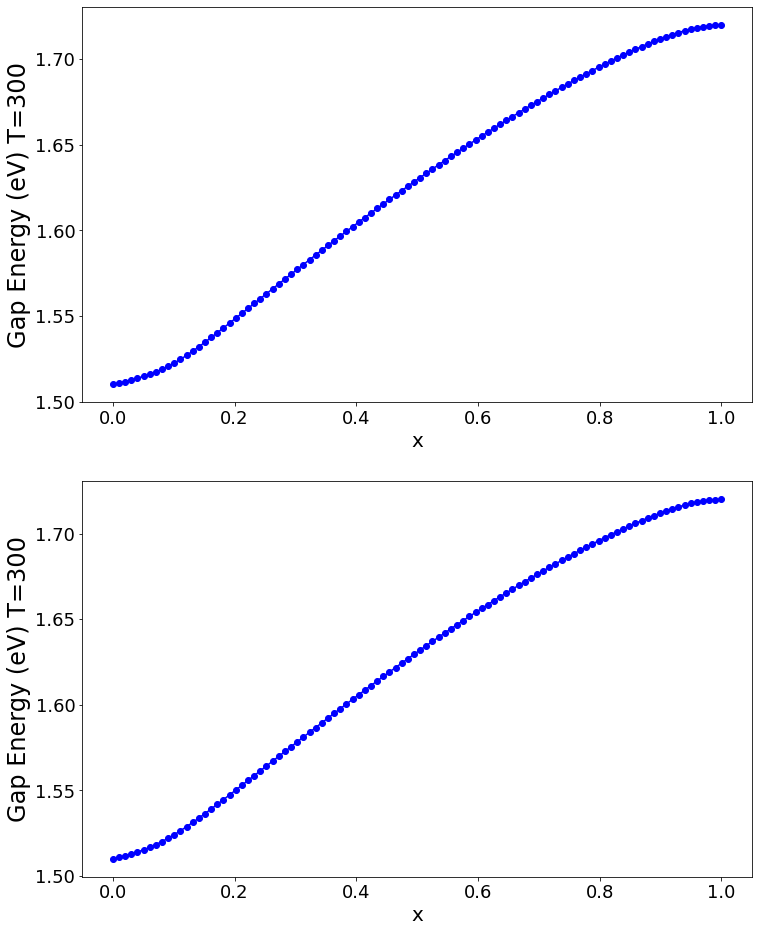

In [ ]:
# Plot of the properties

fig, ax = plt.subplots(2,1,figsize=(12, 16))

ax[0].plot(temp_x, aveg_props["Temperature_"+str(int(240))],'-bo')
ax[0].set_xlabel('x',fontsize=20)
ax[0].set_ylabel('Gap Energy (eV) T=300', fontsize=24)
ax[0].tick_params(labelsize=18)

ax[1].plot(temp_x, aveg_props["Temperature_"+str(int(380))],'-bo')
ax[1].set_xlabel('x', fontsize = 20)
ax[1].set_ylabel('Gap Energy (eV) T=300', fontsize = 24)
ax[1].tick_params(labelsize=18)

plt.show()

**Absorption Coefficient via GQCA Approach**

In [ ]:
T = 300 #selecione a temperatura em kelvin
xuv = 0.50  #selecione a composição 0<x<1
for i in range(0,J):
    archive2 = "uvvis_" + str(i+1) + ".dat"
    if(i==0): #a classe 1 será usada para definir alguns parâmetros
        prov = np.loadtxt(archive2)
        nlins = len(prov[:,0])
        ncols = J
        coefs = np.zeros((nlins,ncols))
        energy_uv = np.zeros((nlins,1))
        energy_uv[:,0] = prov[:,0]
        coefs[:,0] = prov[:,1]
    else:
        prov = np.loadtxt(archive2)
        coefs[:,i] = prov[:,1]

#cálculo das médias
arq_uvvis = "uvvis_average"
#b = str(xuv)
#b = re.sub('[.]', '', b)
#arq_uvvis = arq_uvvis + "_" + b + ".dat"
arq_uvvis = arq_uvvis + ".dat"

prop_file = open(arq_uvvis, "w")
print('%s %f'%("#Temperature:", T), file=prop_file)

for j in range(0,len(energy_uv[:,0])): #Para uma dada temperatura e composição, percorra todas as energias
    energy = energy_uv[j,0]

    if(xuv==0.00):
        print('%.3f %10.4f %10.4f'%(energy, coefs[j,0], float(0.000)), file=prop_file)
    if(xuv==1.00):
        print('%.3f %10.4f %10.4f'%(energy, coefs[j,J-1], float(0.000)), file=prop_file)

    if(xuv>0.00 and xuv<1.00):
        avg = 0.0e0
        rmse = 0.0e0
        sumq = 0.0e0
        a = root_f(xuv,T)
        for k in range(0,J):
            avg = avg + xj(k,T,a)*float(coefs[j,k])
            sumq = sumq + xj(k,T,a)*float(coefs[j,k])*float(coefs[j,k])
            rmse = np.sqrt(sumq - avg*avg)
        print('%.3f %10.4f %10.4f'%(energy, avg, rmse), file=prop_file)
#print('\n', file=prop_file)
prop_file.close()